<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/k-prototype/notebooks/Division_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the unified database



---



---



In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics


raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/master/datasets/dataset_resampled.csv"
df=pd.read_csv(raw_data_url, index_col=False)

categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE'] = pd.to_datetime(df['DATE'],
               format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_REF            1997 non-null   string        
 1   YEAR              1997 non-null   int64         
 2   MONTH             1997 non-null   int64         
 3   ID_SITE_RATTACHE  1997 non-null   string        
 4   QUANTITY          1997 non-null   float64       
 5   CODE_ATC          1997 non-null   string        
 6   HOSPI_CODE_UCD    1997 non-null   string        
 7   N_UFS             1997 non-null   int64         
 8   WEEK              1997 non-null   float64       
 9   N_ETB             1997 non-null   int64         
 10  POPULATION        1997 non-null   float64       
 11  P_MEDICAL         1997 non-null   int64         
 12  PN_MEDICAL        1997 non-null   int64         
 13  LIT_HC            1997 non-null   float64       
 14  LIT_HP            1997 n

# 1 - Database formatting

## 1.1 - Data inconsistance handling

In [51]:
df = df.drop_duplicates()
df = df.dropna()

for column in numerical_features:
  zeros = (df[column] == 0).sum()
  print(f'Column: {column}' + f' number of zeros: {zeros}')

Column: N_UFS number of zeros: 0
Column: QUANTITY number of zeros: 0
Column: N_ETB number of zeros: 0
Column: POPULATION number of zeros: 0
Column: P_MEDICAL number of zeros: 0
Column: PN_MEDICAL number of zeros: 0
Column: LIT_HC number of zeros: 0
Column: LIT_HP number of zeros: 0
Column: SEJ_MCO number of zeros: 0
Column: SEJ_HAD number of zeros: 1473
Column: SEJ_PSY number of zeros: 459
Column: SEJ_SSR number of zeros: 0


## 1.2 - Separating databases by hospital

In [52]:
# Separating databases

n_medicines = df['ID_REF'].nunique()
print('Number of different medicines: ', n_medicines)

df_h1 = df[df["ID_SITE_RATTACHE"] == "HOSPI_1"]
df_h2 = df[df["ID_SITE_RATTACHE"] == "HOSPI_2"]
df_h3 = df[df["ID_SITE_RATTACHE"] == "HOSPI_3"]
df_h4 = df[df["ID_SITE_RATTACHE"] == "HOSPI_4"]

Number of different medicines:  84


# Helper functions

In [4]:
'''
   This function helps visualize the values of numerical columns in a DataFrame,
   making it easier to understand their patterns and distributions.
'''

def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [66]:
from pandas.core.reshape.merge import string
'''
  This function provides a convenient way to visualize the distribution of numerical
  columns in a DataFrame using histograms with optional kernel density estimation.
'''

def visualize_distribution(df, data_type='numerical', n_cols=3):
    if data_type == 'numerical':
        columns = df.select_dtypes(include=[int, float]).columns
    elif data_type == 'categorical':
        columns = df.select_dtypes(include=[object, 'string']).columns
    else:
        raise ValueError("Invalid data_type parameter. Supported values: 'numerical', 'categorical'")

    if len(columns) == 0:
        raise ValueError("No columns of the specified data type found in the DataFrame.")

    num_features = len(columns)
    n_rows = m.ceil(num_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    # Set a predefined color palette
    palette = sns.color_palette("Set3", n_colors=num_features)

    for i, column in enumerate(columns):
        ax = axes[i // n_cols, i % n_cols]
        if data_type == 'numerical':
            sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        elif data_type == 'categorical':
            sns.countplot(x=column, data=df, ax=ax, palette=[palette[i]])
            ax.tick_params(axis='x', rotation=45)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()



In [6]:
'''
  Display unique values in dataframe
'''
def display_unique(df, kind = 'Categorical'):

  if kind == 'Categorical':
    features = df.select_dtypes(include=['object', 'string'])
  if kind == 'Numerical':
    features = df.select_dtypes(include=[int, float])
  if kind == 'Both':
    features = df.columns

  for column in features:
    print(f'\n Unique values of feature: {column}')
    print(df[column].unique())
    print('\n')

In [89]:
def kmeans_clustering(X, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300)
    model.fit(X)
    return model

In [104]:
def evaluate_kmeans_clustering(X_train, X_test, n_clusters=2, metric='euclidean'):
    model = kmeans_clustering(X_train, n_clusters)
    y_pred = model.predict(X_test)
    silhouette = metrics.silhouette_score(X_test, y_pred, metric=metric)
    davies_bouldin = metrics.davies_bouldin_score(X_test, y_pred)
    calinski_harabasz = metrics.calinski_harabasz_score(X_test, y_pred)

    metrics_string = '#'*10+' Metrics for test split - '+f'{n_clusters} clusters '+'#'*10
    print()
    print('#'*len(metrics_string))
    print(metrics_string)
    print()
    print(f'Silhouette Score: {round(silhouette, 2)}')
    print(f'Davies-Bouldin Score: {round(davies_bouldin, 2)}')
    print(f'Calinski-Harabasz Score: {round(calinski_harabasz, 2)}')
    print()
    print('#'*len(metrics_string))
    print('#'*len(metrics_string))
    print()

In [8]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text = "x={:.1f}, y={:.2f}".format(xmax, ymax)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60", color="black")  # Set arrow color to black
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94, 0.96), **kw)

In [9]:
def annot_min(x, y, ax=None):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text_min = "x={:.1f}, y={:.2f}".format(xmin, ymin)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60", color="black")  # Set arrow color to black
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text_min, xy=(xmin, ymin), xytext=(0.9, 0.3), **kw)

## 2 - Data treatment

The data treatment part was done in the notebook [Timeseries exploration](https://github.com/douglasmmachado/MedicineConsumption/blob/master/notebooks/Timeseries_Analysis.ipynb). In the present notebook, we are using a dataset without outliers and strange data

## Hospital 1

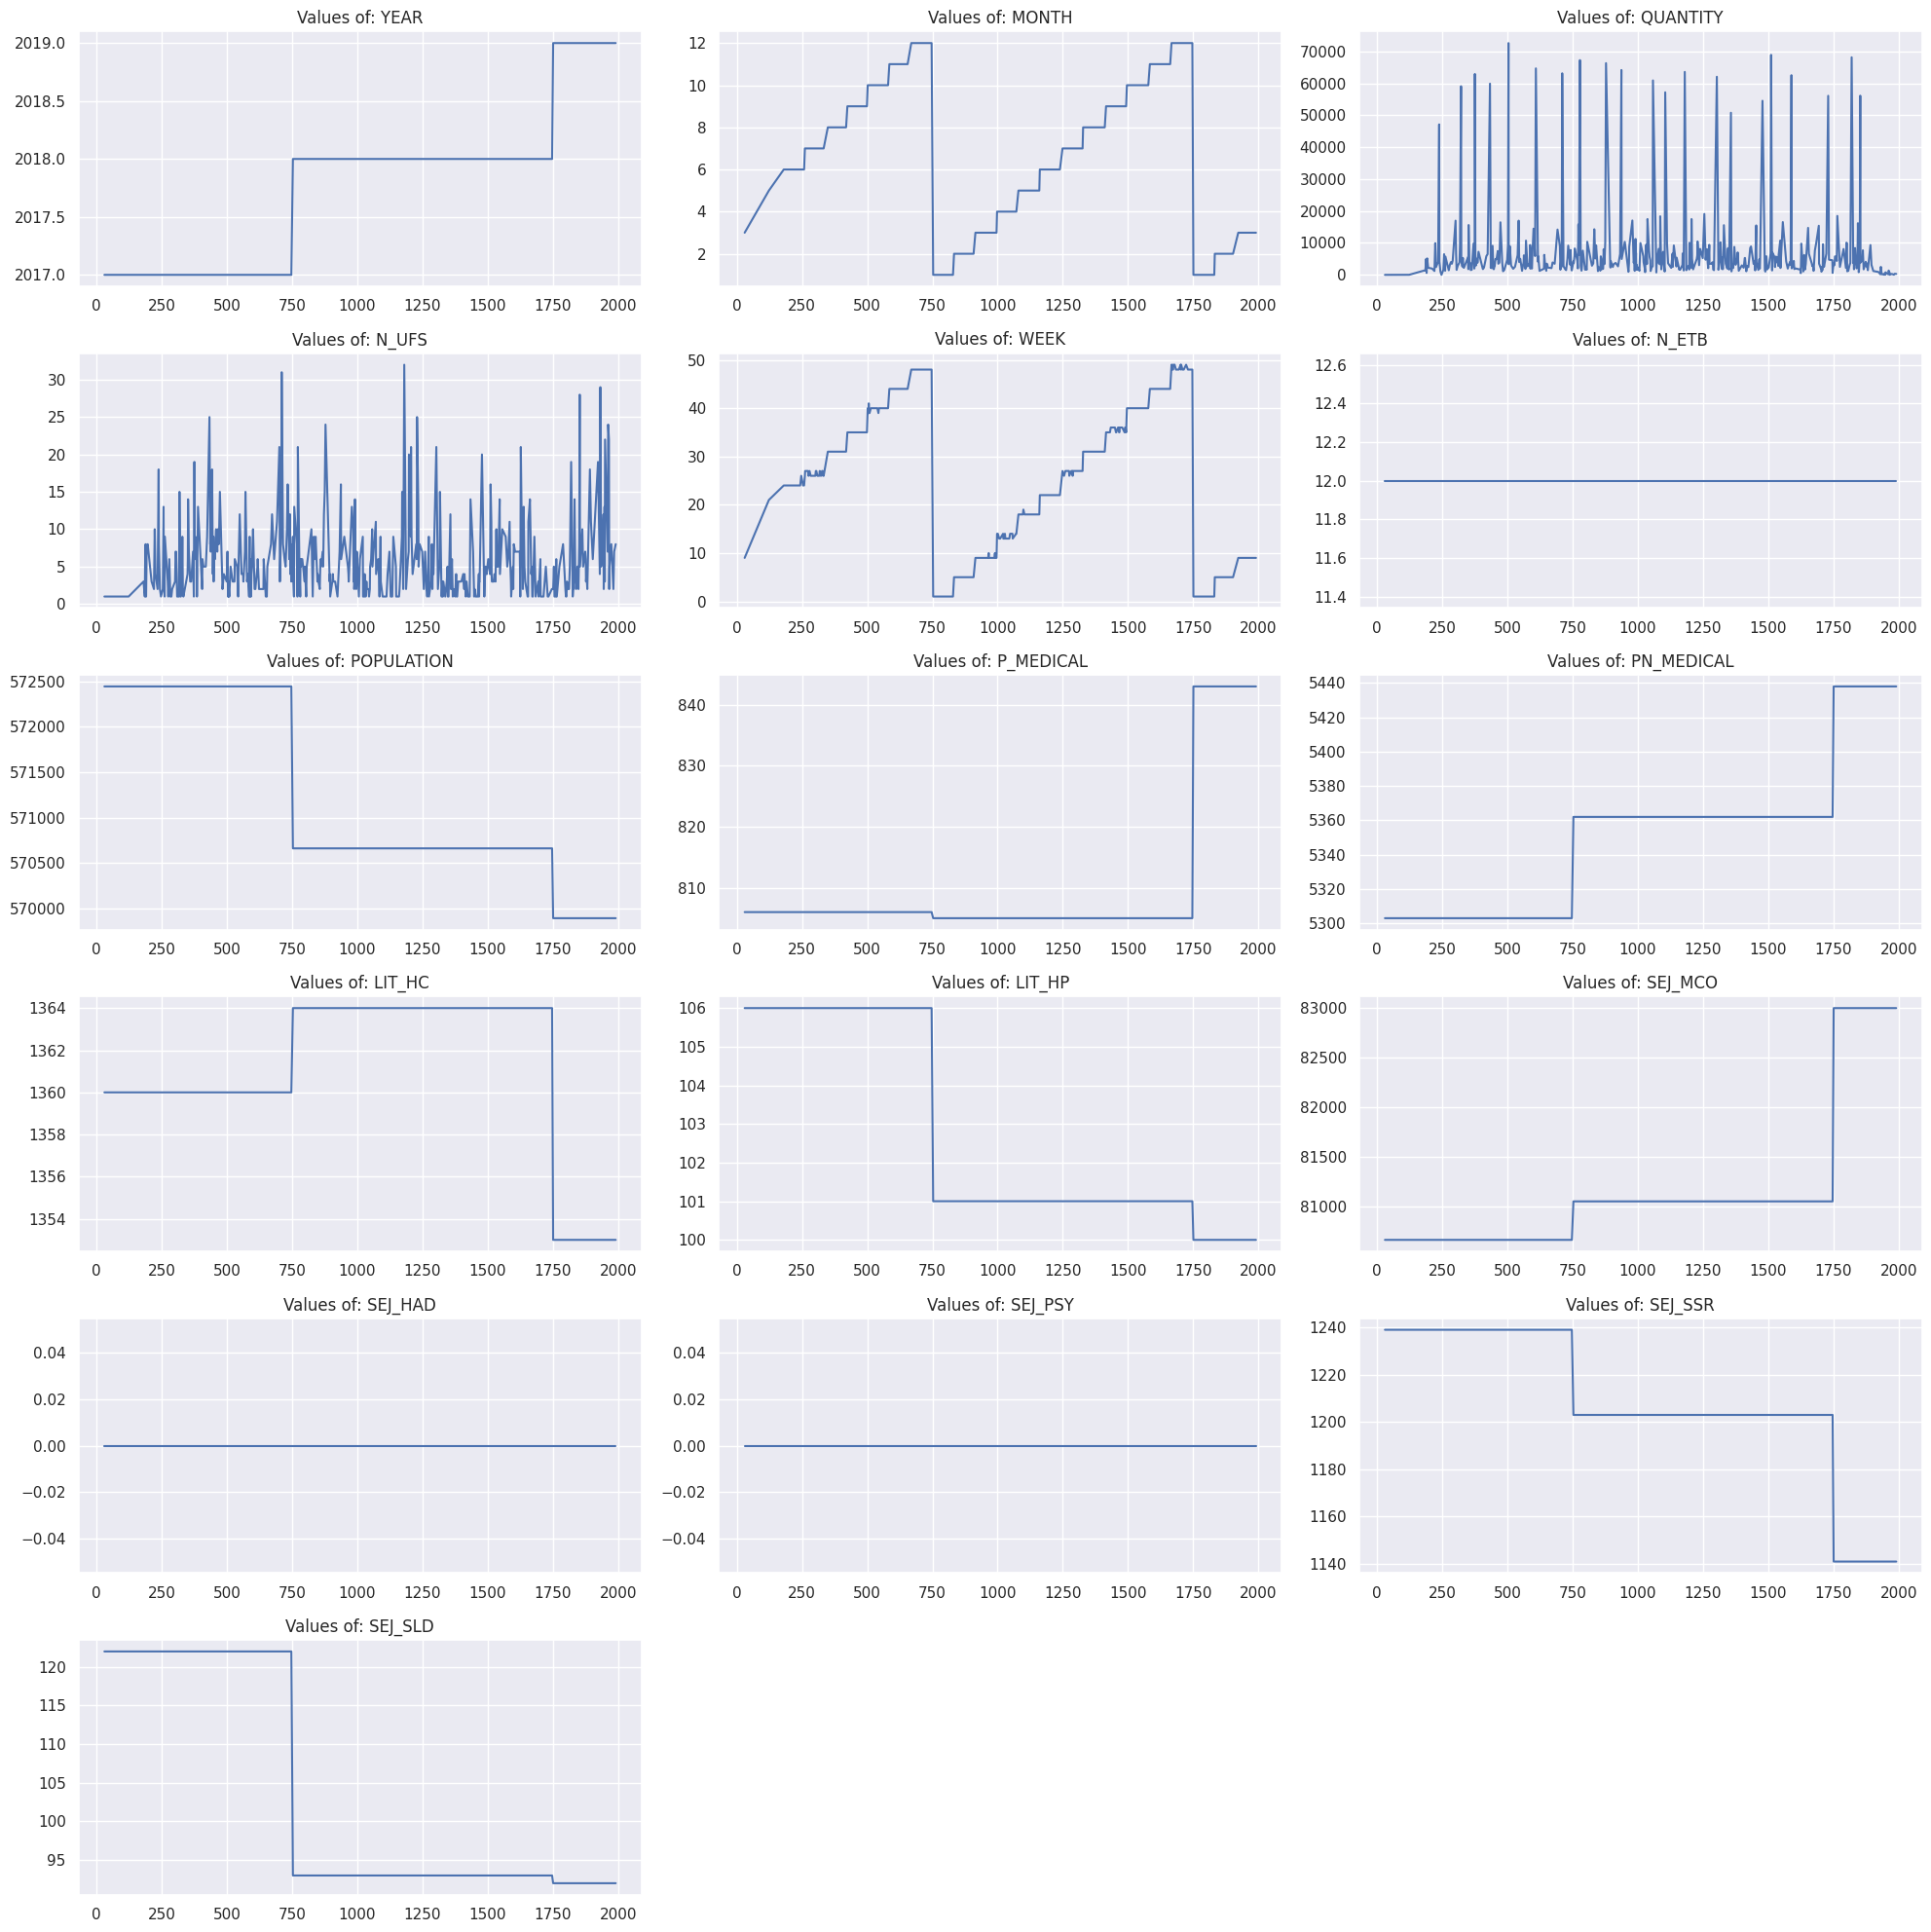

In [53]:
# Visualizing values of numerical features
plot_df(df_h1)

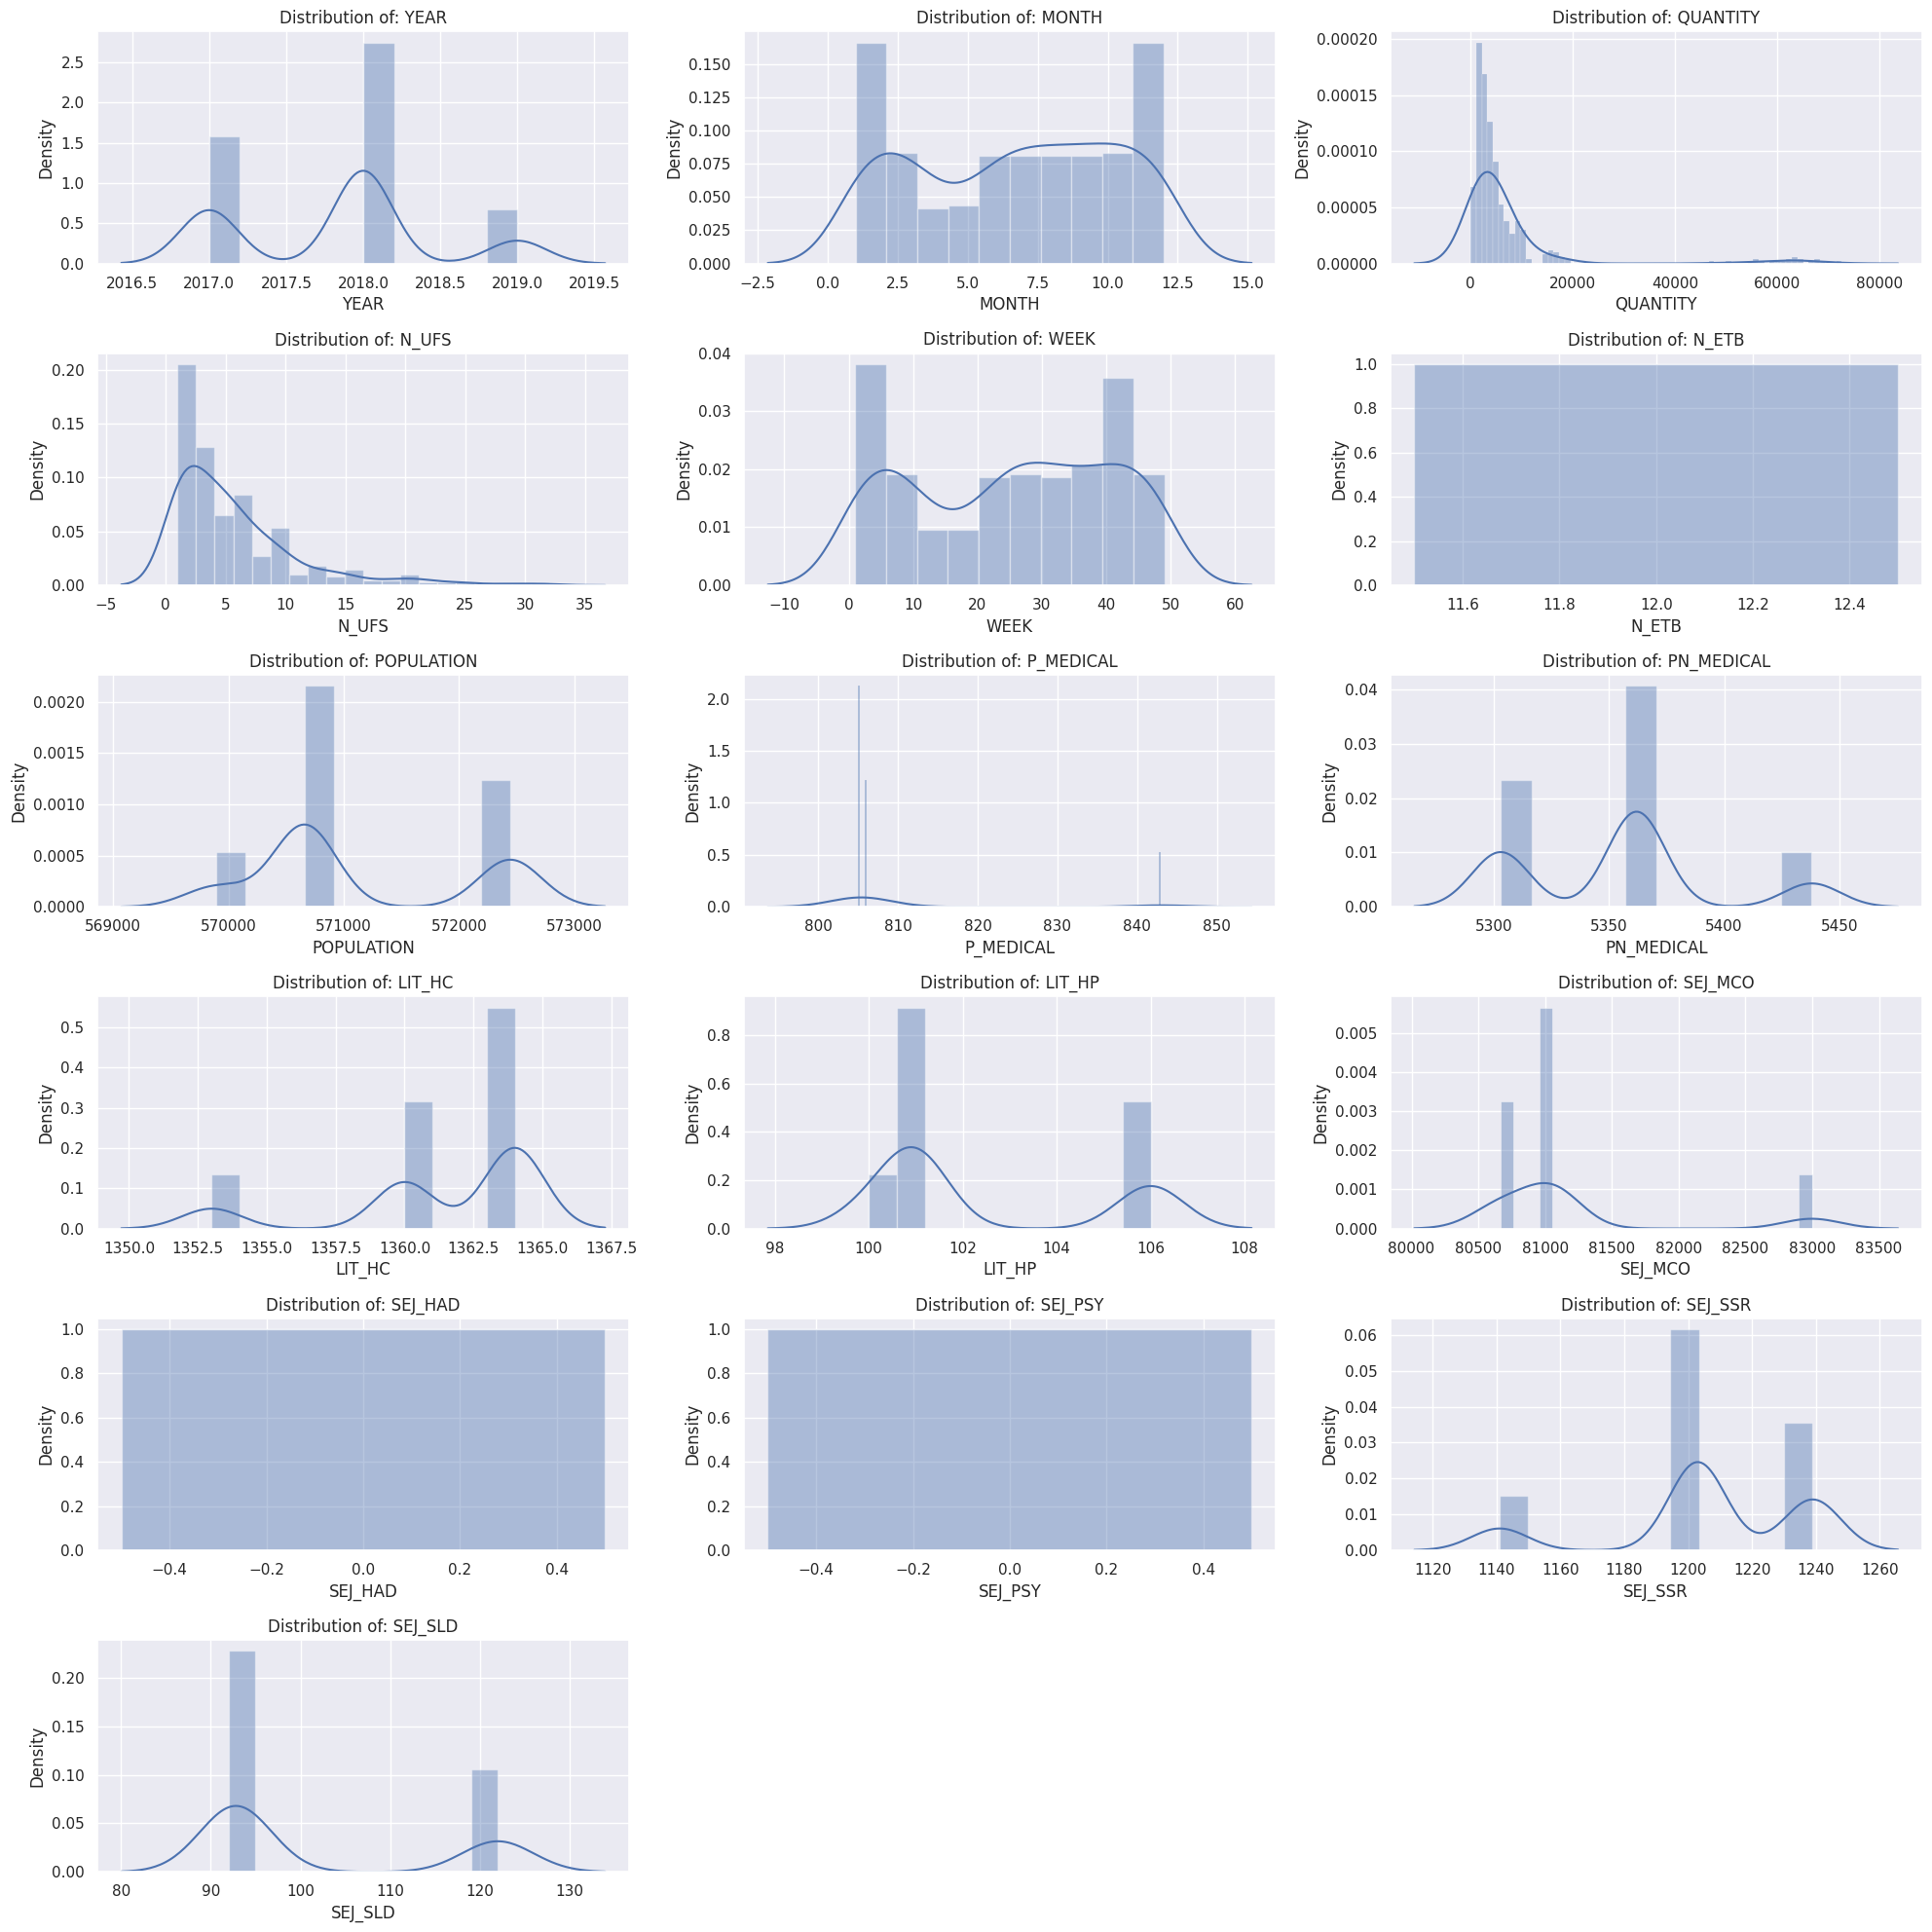

In [67]:
visualize_distribution(df_h1)

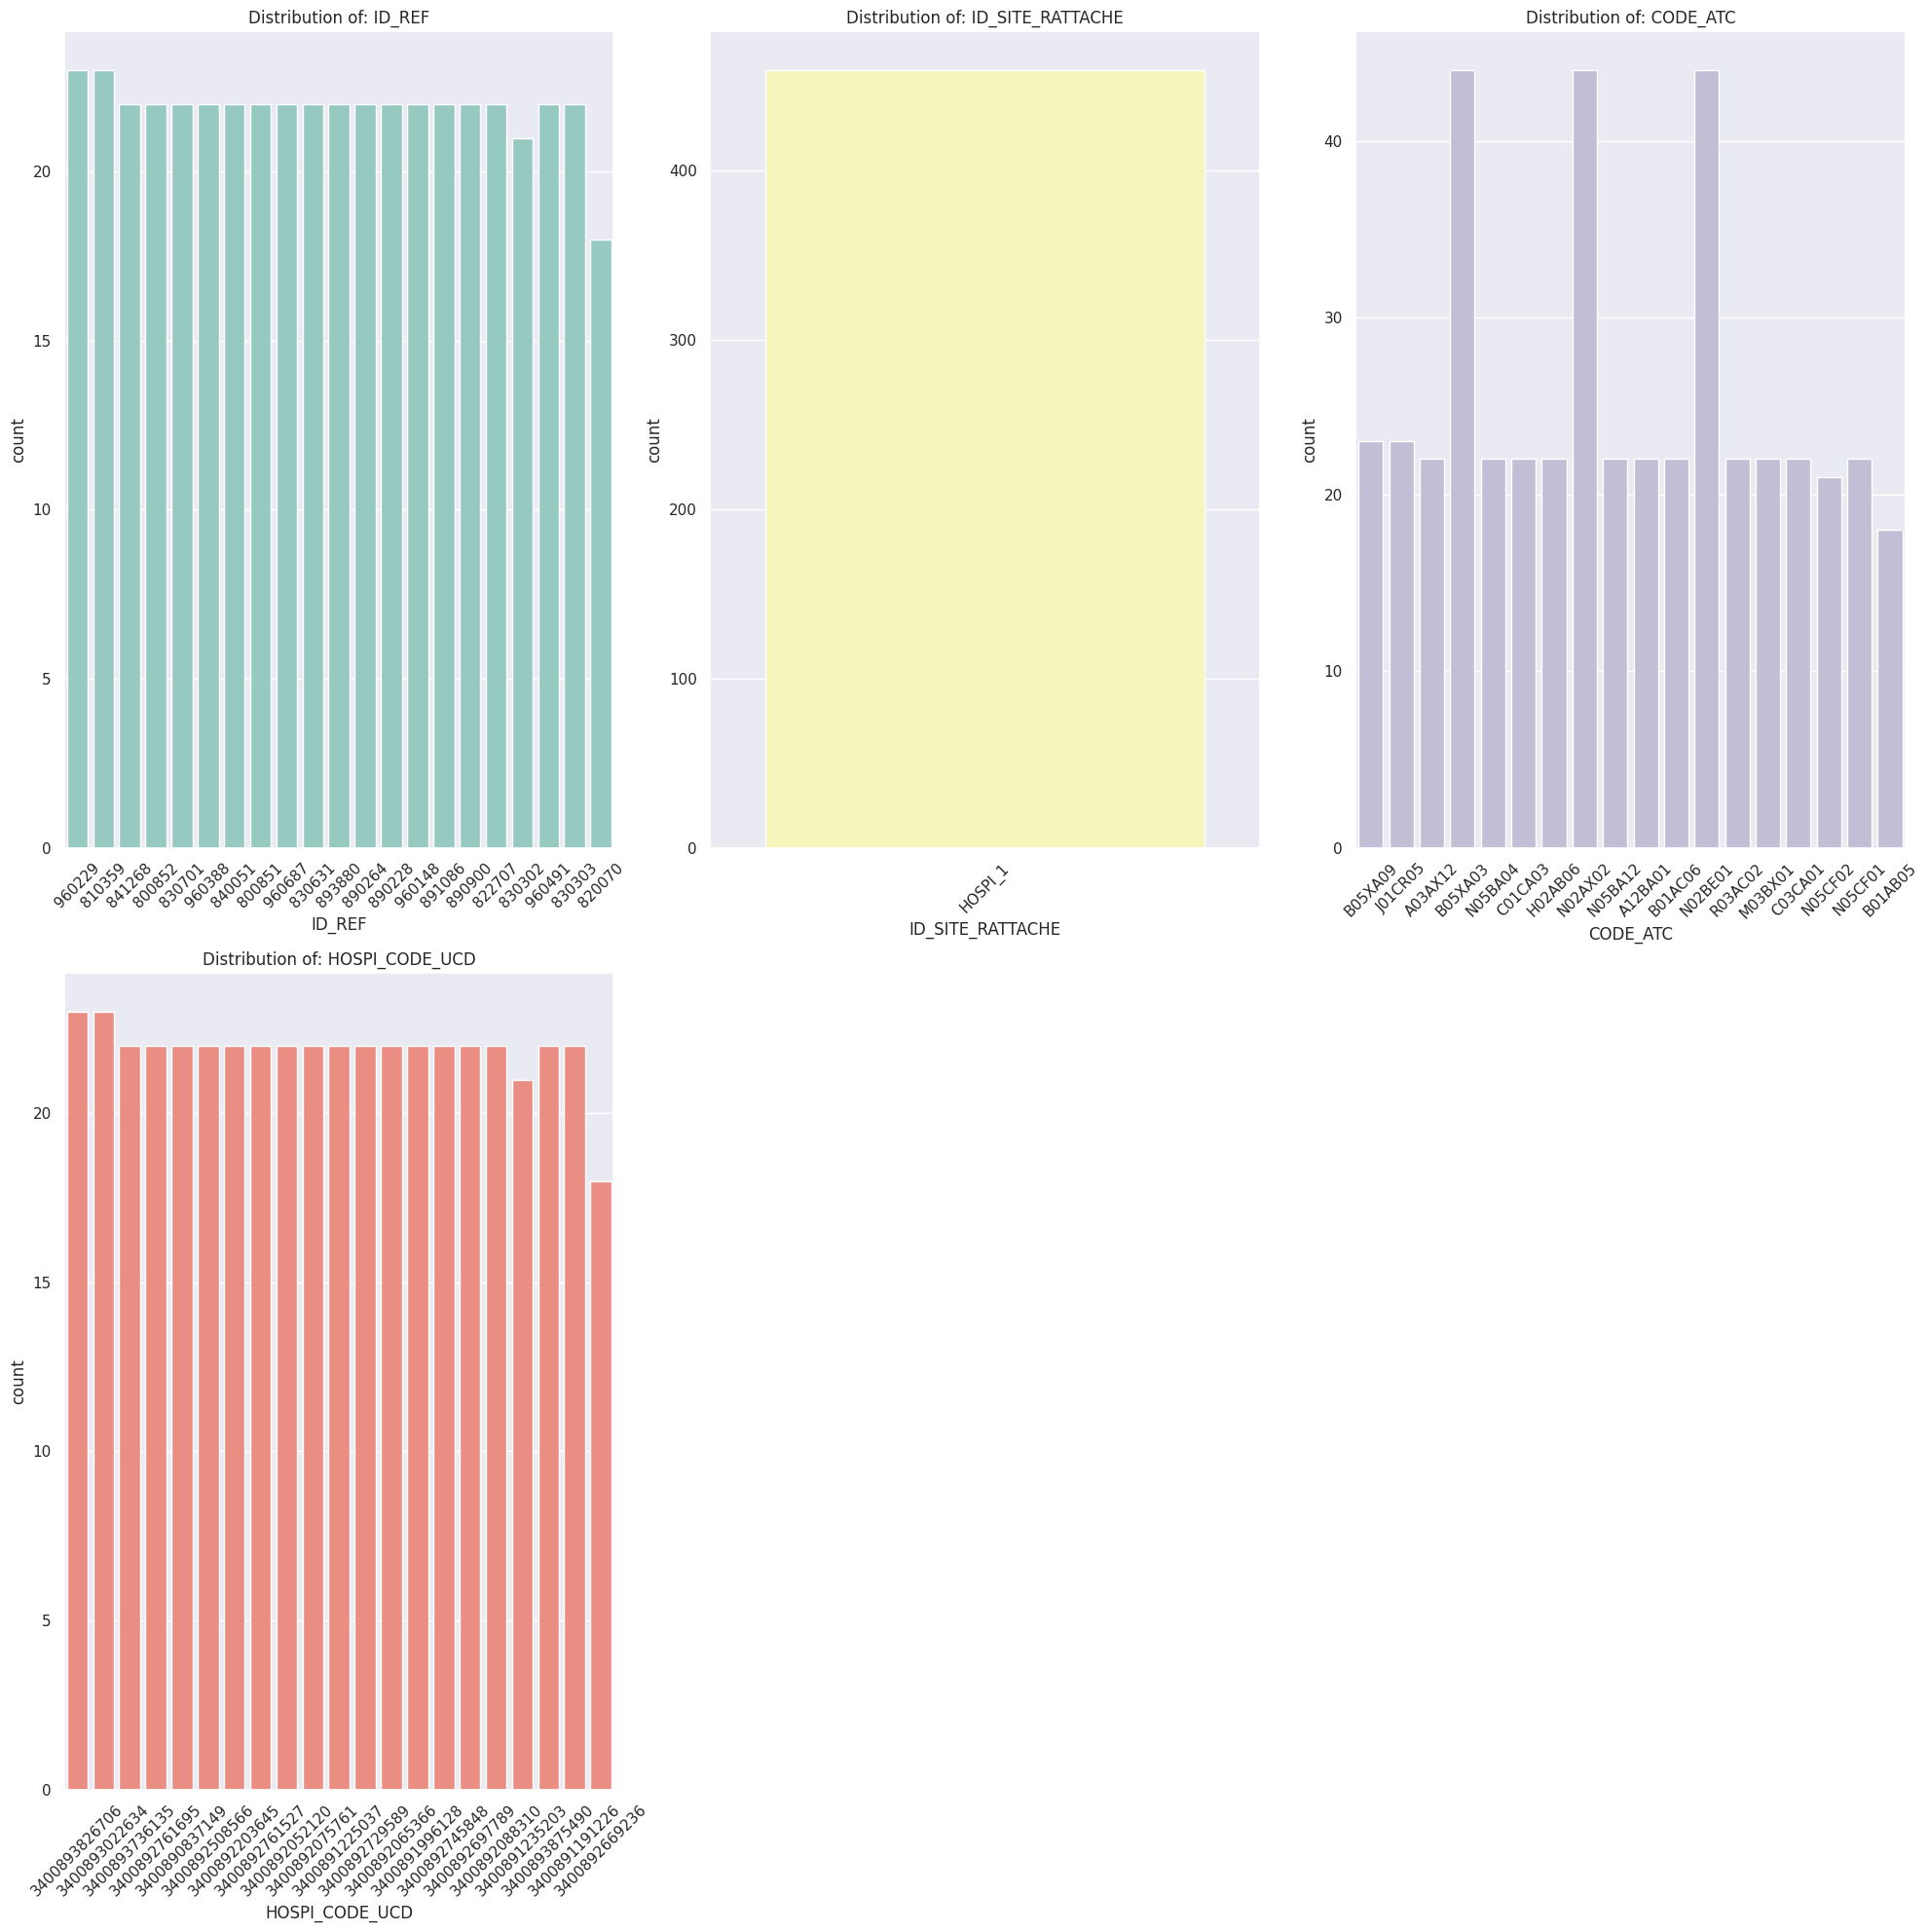

In [68]:
# Question to be asked:  As ID_REF and HOSPI_CODE_UCD are the same information, can we eliminate one column?

visualize_distribution(df_h1, data_type='categorical')

## 2.4 - Transforming categorical features

In [69]:
pd.set_option('mode.chained_assignment', None)

df_h1["ID_REF"] = df_h1["ID_REF"].astype(int)
df_h1["HOSPI_CODE_UCD"] = df_h1["HOSPI_CODE_UCD"].astype(int)

change = {'N02BE01':'1','A12BA01':'2','B05XA03':'3',
          'B01AB05':'4','B01AC06':'5','N05BA04':'6',
          'N02AX02':'7','N05CF01':'8','R03AC02':'9',
          'H02AB06':'10','A03AX12':'11','N05BA12':'12',
          'B05XA09':'13','M03BX01':'14','C01CA03':'15',
          'N05CF02':'16','C03CA01':'17','J01CR05':'18'}

df_h1["CODE_ATC"] = df_h1['CODE_ATC'].replace(change)
df_h1["CODE_ATC"] = df_h1["CODE_ATC"].astype(int)

# 3 - Feature manipulation and comprehension

## 3.1 - Correlation analysis

<Axes: >

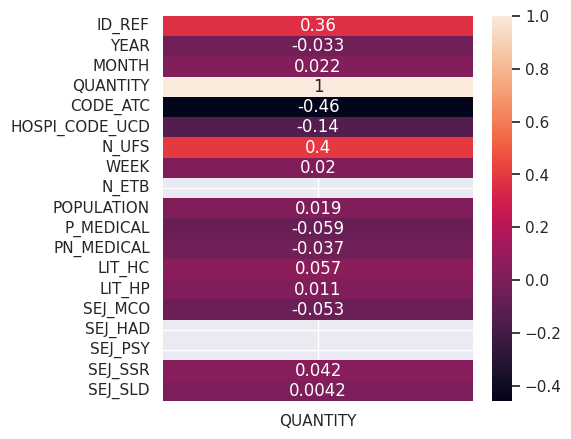

In [70]:
corr = df_h1.corr(numeric_only=True)
x = corr[['QUANTITY']]
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(x,annot=True)

<Axes: >

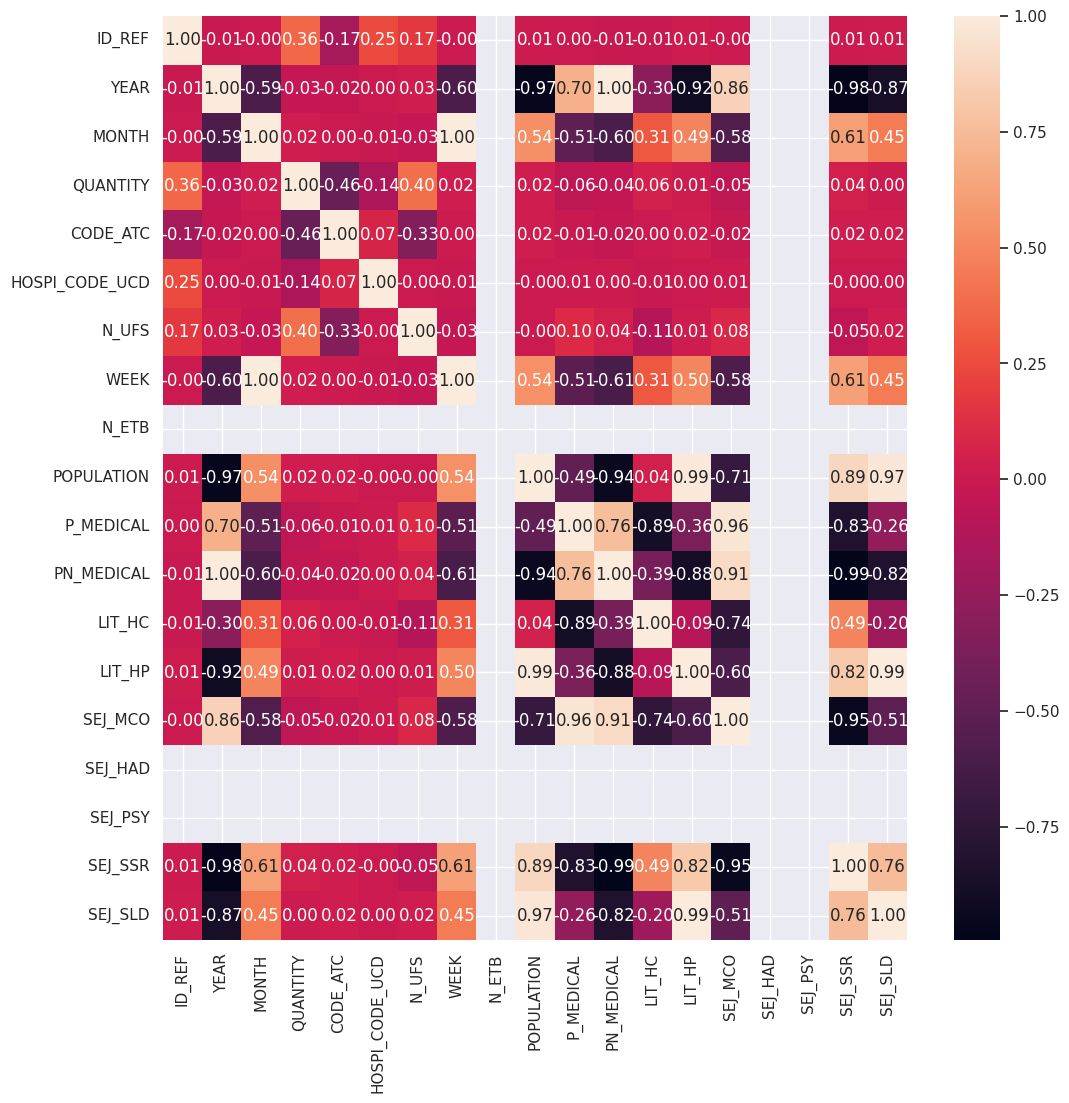

In [71]:
'''
  The constant values are not displayed in the correlation.
'''

corr = df_h1.corr(numeric_only=True)
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, annot=True, fmt='.2f')


## 3.2 - Normalize / Scale data

In [72]:
df_h1_numerical = df_h1.copy()
df_h1_numerical = df_h1_numerical.drop(['ID_SITE_RATTACHE','DATE'], axis=1)
df_h1_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 30 to 1991
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_REF          459 non-null    int64  
 1   YEAR            459 non-null    int64  
 2   MONTH           459 non-null    int64  
 3   QUANTITY        459 non-null    float64
 4   CODE_ATC        459 non-null    int64  
 5   HOSPI_CODE_UCD  459 non-null    int64  
 6   N_UFS           459 non-null    int64  
 7   WEEK            459 non-null    float64
 8   N_ETB           459 non-null    int64  
 9   POPULATION      459 non-null    float64
 10  P_MEDICAL       459 non-null    int64  
 11  PN_MEDICAL      459 non-null    int64  
 12  LIT_HC          459 non-null    float64
 13  LIT_HP          459 non-null    float64
 14  SEJ_MCO         459 non-null    int64  
 15  SEJ_HAD         459 non-null    int64  
 16  SEJ_PSY         459 non-null    int64  
 17  SEJ_SSR         459 non-null    i

### Standardize the features

In [73]:
# Normalizing data
X = df_h1_numerical.values
X.shape

(459, 19)

In [74]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## 3.3 - Dimensionality reduction with PCA

Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.


In Scikit-learn, [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is applied using the PCA() class. It is in the decomposition submodule in Scikit-learn. The most important hyperparameter in that class is n_components.


In [75]:
pca_19 = PCA(n_components = X.shape[1], random_state = 42)
pca_19.fit(X_scaled)
X_pca_19 = pca_19.transform(X_scaled)

In [76]:
print(f"Variance explained by all 19 principal components: {sum(pca_19.explained_variance_ratio_ * 100):.2f}")

Variance explained by all 19 principal components: 100.00


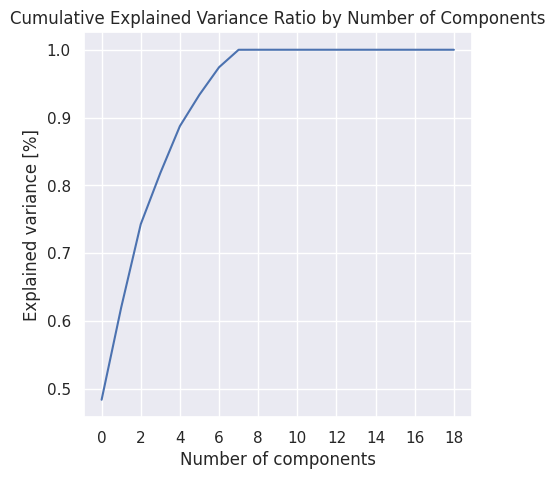

In [77]:
'''
  We can notice here that the first 6 components keep 99% of the variability
  in the dataset while reducing 12 features in the dataset.
'''

cumsum_X = np.cumsum(pca_19.explained_variance_ratio_)

# Set the figure size to 12 by 12
plt.figure(figsize=(5, 5))

plt.plot(cumsum_X)
plt.xlabel('Number of components')
plt.ylabel('Explained variance [%]')

# Set the tick locations and labels
tick_locations = np.arange(0, len(cumsum_X), 2)
tick_labels = np.arange(0, len(cumsum_X), 2, dtype=int)
plt.xticks(tick_locations, tick_labels)

plt.title("Cumulative Explained Variance Ratio by Number of Components")

plt.show()


### 2 components

In [78]:
pca_2 = PCA(n_components = 2, random_state = 42)
pca_2.fit(X_scaled)
X_pca_2 = pca_2.transform(X_scaled)

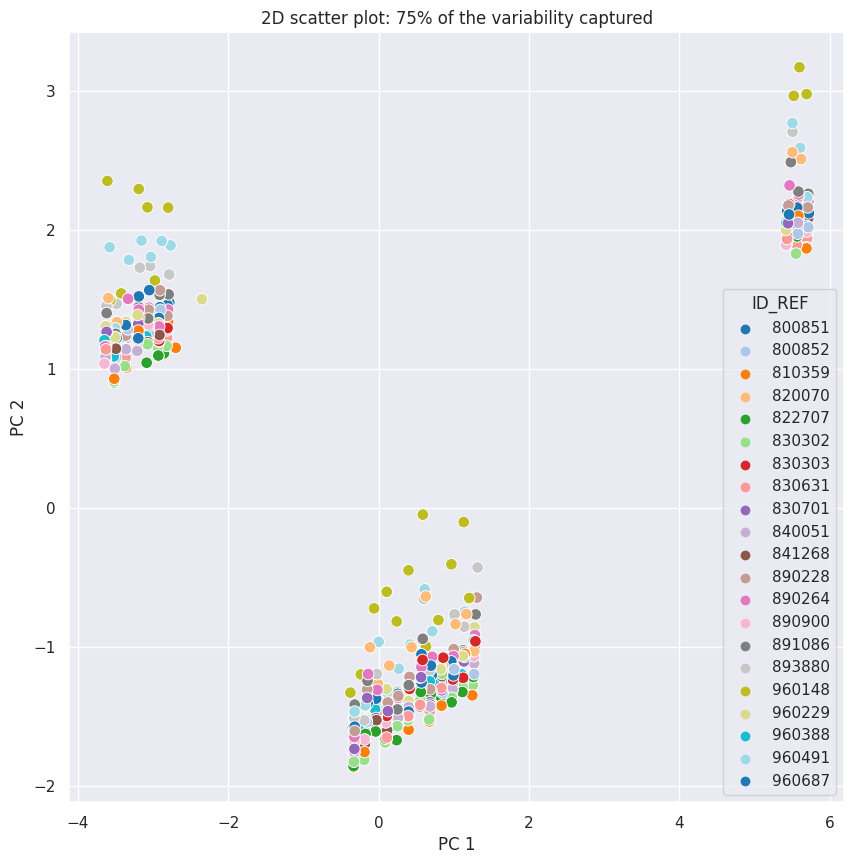

In [79]:
unique_values = df_h1_numerical.ID_REF.unique()
palette = sns.color_palette('tab20', n_colors=len(unique_values))

plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_pca_2[:, 0],
                y=X_pca_2[:, 1],
                s=70,
                hue=df_h1_numerical.ID_REF,
                palette=palette)

plt.title('2D scatter plot: 75% of the variability captured')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()


### 3 components

In [80]:
pca_3 = PCA(n_components = 3, random_state = 42)
pca_3.fit(X_scaled)
X_pca_3 = pca_3.transform(X_scaled)

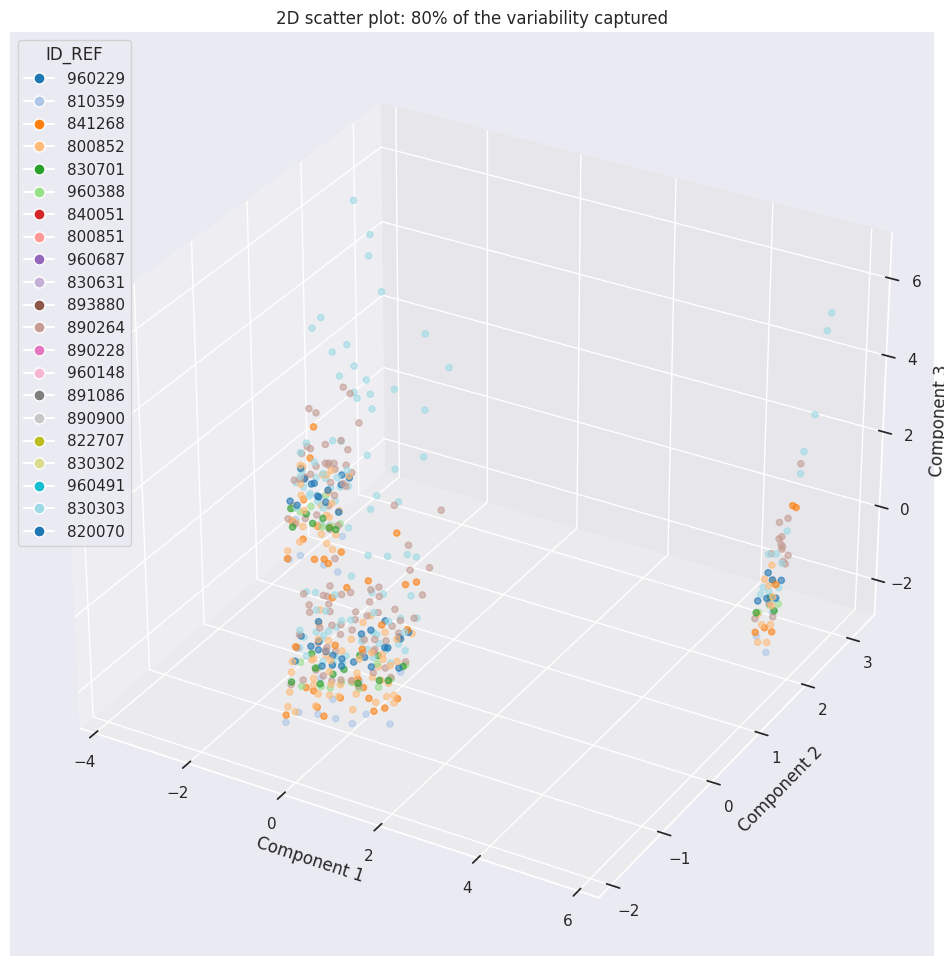

In [81]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

# Scatter plot
sctt = ax.scatter3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2],
                    c=df_h1_numerical.ID_REF, cmap='tab20', s=20, alpha=0.6)

# Legend
unique_values = df_h1_numerical.ID_REF.unique()
legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(value),
                         markerfacecolor=palette[i], markersize=8)
                   for i, value in enumerate(unique_values)]
ax.legend(handles=legend_elements, title='ID_REF')

# Title and axis labels
ax.set_title('2D scatter plot: 80% of the variability captured')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()


### PCA 95

Let’s apply PCA to our dataset with n_components=0.95. This will select the number of components while preserving 95% of the variability in the data. The retrieved shape was (459,7), which means that the algorithm has found 7 principal components to preserve 95% of the variability in the data.

In [82]:

'''
  pca_95.get_params(deep=True)
  {'copy': True,
  'iterated_power': 'auto',
  'n_components': 0.95,
  'n_oversamples': 10,
  'power_iteration_normalizer': 'auto',
  'random_state': 42,
  'svd_solver': 'auto',
  'tol': 0.0,
  'whiten': False}

'''
pca_95 = PCA(n_components = 0.95, random_state = 42)
pca_95.fit(X_scaled)
X_pca_95 = pca_95.transform(X_scaled)
X_pca_95.shape

(459, 7)

In [83]:

print(pca_95.explained_variance_ratio_)

print(pca_95.singular_values_)


[0.48409358 0.1359384  0.12286368 0.07537867 0.06915922 0.04634728
 0.04040857]
[59.62535767 31.59638599 30.03848968 23.52830065 22.53675471 18.44923889
 17.22673944]


In [84]:
print(abs( pca_95.components_[0]))

[0.0024737  0.35277232 0.2562864  0.0139178  0.00787063 0.00184767
 0.01800832 0.25770926 0.         0.32978301 0.27702    0.35529774
 0.1469171  0.30824808 0.32686177 0.         0.         0.35424479
 0.28670982]


In [85]:
df_h1_reduced = pd.DataFrame(X_pca_95,
                             columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])
df_h1_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.352389,1.500423,-0.882817,2.712662,2.035531,-0.592837,-0.166092
1,-2.700261,1.151263,-2.316191,0.579956,1.382202,0.256308,0.353335
2,-2.806643,1.305274,-1.218034,1.245459,0.950618,0.733420,-0.557533
3,-2.801977,1.275231,-0.859431,-0.326006,1.121059,0.622268,-1.775719
4,-2.808804,1.481256,-0.397182,2.504535,0.845201,-0.214067,0.281903


# 4 - Clustering

## 4.1 - Train, test split

## 4.2 - K-means different models

## 4.3 - Model evaluation

